## **This python notebook is used to train a model to identify a loan defaulter/charge off vs fully paid loan status for the loan dataset. **

---



In [0]:
# Import basic data science packages
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
%matplotlib inline
from sklearn import metrics, svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import re
import xgboost as xgb

In [0]:
df = pd.read_csv("ML.csv")
df.shape
df=df.drop(['Unnamed: 0'],axis=1)

**Removing the Serial number column and converting the Loan_status column into a target variable with 1: Charged Off and 0:Fully paid. The data is split into testing(30%) and training(70%) with a stratified split using the target.**

In [0]:
from sklearn.model_selection import train_test_split
def score_to_numeric(x):
    if x=='Fully Paid':
        return 0
    if x=='Charged Off':
        return 1
df = df[df['loan_status']!='Current']
df['Target'] = df['loan_status'].apply(score_to_numeric)
df['Target']
df = df.drop(['member_id','recoveries','collection_recovery_fee'], axis=1)
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in df.columns.values]
X = df.drop(['loan_status','Target'], axis=1)
y = df.pop('Target')
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.30, random_state=42, stratify=y)

**Training using a decision tree. Looks like accuracy is 100%. Testing accuracy is 94%. The model is clearly overfit.**

In [94]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

print("Decision tree - Normal data set")
print(metrics.accuracy_score(y_train, dt.predict(X_train)))
print(metrics.accuracy_score(y_test, dt.predict(X_test)))
print(metrics.confusion_matrix(y_test, dt.predict(X_test)))

Decision tree - Normal data set
1.0
0.9437593276254811
[[10517   357]
 [  359  1498]]


**Training the model using a xgboost classifier. There is a lot of variation between the test and train accuracies showing the problem of overfitting.**

In [95]:
# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)
print(model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [96]:
y_pred = model.predict(X_train)
accuracy = accuracy_score(y_train, y_train)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# make predictions for test data
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 100.00%
Accuracy: 94.41%


**Looking at the variable importance chart to restrict model training to the top variables. The feature engineered columns show up as important variables here.**

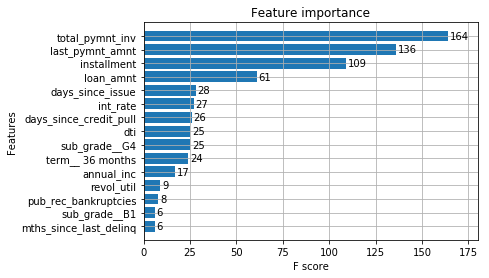

In [97]:
xgb.plot_importance(model, max_num_features=15, height=0.8)
plt.show()

In [0]:
X=X[['last_pymnt_amnt','installment','total_pymnt_inv','int_rate','loan_amnt','term__ 36 months','dti','purpose__small_business','days_since_issue','days_since_credit_pull']]
#y = df.pop('loan_status')
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.25, random_state=42, stratify=y)

**The model is trained on the reduced feature list. The accuracy is very similar to the model above suggesting that we can stick to using just the selected columns for modelling and scoring.**

In [99]:
# fit model on training data
model = XGBClassifier()
model.fit(X_train, y_train)
print(model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [100]:
y_pred = model.predict(X_train)
accuracy = accuracy_score(y_train, y_train)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# make predictions for test data
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 100.00%
Accuracy: 94.38%


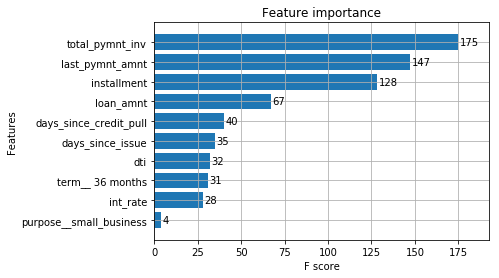

In [101]:
xgb.plot_importance(model, max_num_features=50, height=0.8)
plt.show()

**As the model seems to overfit, cross validation can be used to build multiple models during training and reduce the problem of overfitting on the training data.**

In [0]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [104]:
xgtrain = xgb.DMatrix(X_train, label=y_train)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [0]:
clf = xgb.XGBClassifier(missing=9999999999,
                max_depth = 5,
                n_estimators=100,
                learning_rate=0.1, 
                nthread=4,
                subsample=0.8,
                colsample_bytree=0.5,
                min_child_weight = 3,
                seed=1301)
xgb_param = clf.get_xgb_params()

In [106]:
from sklearn.metrics import roc_auc_score
print ('Start cross validation')
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=500, nfold=2, metrics=['auc'],
     early_stopping_rounds=20, stratified=True, seed=1301)
print('Best number of trees = {}'.format(cvresult.shape[0]))
clf.set_params(n_estimators=cvresult.shape[0])
print('Fit on the training data')
clf.fit(X_train, y_train, eval_metric='auc')
print('Overall AUC:', roc_auc_score(y_train, clf.predict_proba(X_train)[:,1]))
print('Predict the probabilities based on features in the test set')
pred = clf.predict_proba(X_test, ntree_limit=cvresult.shape[0])


Start cross validation
Best number of trees = 388
Fit on the training data
Overall AUC: 0.9983240964345277
Predict the probabilities based on features in the test set


In [127]:
print("cross validated model training accuracy: %.2f%%" % (metrics.accuracy_score(y_train, clf.predict(X_train)) * 100.0))
print("cross validated model testing accuracy: %.2f%%" % (metrics.accuracy_score(y_test, clf.predict(X_test)) * 100.0))

print(metrics.confusion_matrix(y_test, clf.predict(X_test)))
y_test.value_counts()

cross validated model training accuracy: 98.68%
cross validated model testing accuracy: 97.37%
[[8160   78]
 [ 176 1231]]


0    8238
1    1407
Name: Target, dtype: int64

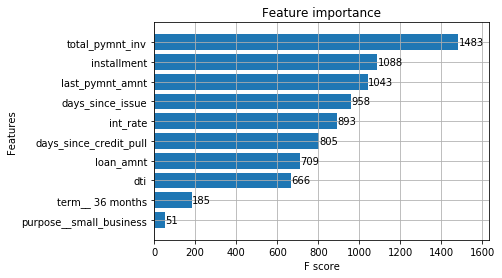

In [125]:
xgb.plot_importance(clf, max_num_features=50, height=0.8)
plt.show()

AUC: 0.990


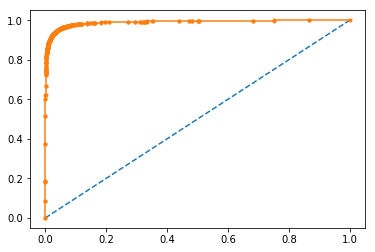

In [132]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
probs = clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

**As seen above, the model that was crossvalidated in training has very little variation between training and testing accuracies. The accuracy score is also very good. This model is suitable for deployment.**